In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

In [2]:
df = pd.read_excel('relay-foods.xlsx')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


## 1.创建OrderPeriod列

### 由于是分析月度数据，所以不需要日

In [3]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


### 2.确定用户组（基于首次购买）
##### 创建一个新列，取名用户组，内容是用户首次购买的年和月

In [4]:
df.set_index('UserId', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


3. Rollup data by CohortGroup & OrderPeriod
Since we're looking at monthly cohorts, we need to aggregate users, orders, and amount spent by the CohortGroup within the month (OrderPeriod).
### 处理数据
##### 对users,orders,进行聚合分析

In [5]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
# 计算每个用户、订单的总收益和周期
cohorts = grouped.agg({'UserId': pd.Series.nunique,  # 返回对象中唯一元素的数量。
                       'OrderId': pd.Series.nunique, # 返回对象中唯一元素的数量。
                       'TotalCharges': np.sum})

# make the column names more meaningful
# 重命名列，使其意思明确
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01              22           30      1850.255
            2009-02               8           25      1351.065
            2009-03              10           26      1357.360
            2009-04               9           28      1604.500
            2009-05              10           26      1575.625

4. Label the CohortPeriod for each CohortGroup
We want to look at how each cohort has behaved in the months following their first purchase, so we'll need to index each cohort to their first purchase month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second, and so on.

This allows us to compare cohorts across various stages of their lifetime.
#### 查看每个用户从首次购买后间隔几个月后再次购买

In [9]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30      1850.255             1
            2009-02               8           25      1351.065             2
            2009-03              10           26      1357.360             3
            2009-04               9           28      1604.500             4
            2009-05              10           26      1575.625             5

5. Make sure we did all that right<br>
Let's test data points from the original DataFrame with their corresponding values in the new cohorts DataFrame to make sure all our data transformations worked as expected. As long as none of these raise an exception, we're good.
#### 验证数据

In [10]:
x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-01')]
y = cohorts.ix[('2009-01', '2009-01')]

d:\python\envs\jupyterpy36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [12]:
x.shape

(30, 9)

In [16]:
cohorts.head()

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30      1850.255             1
            2009-02               8           25      1351.065             2
            2009-03              10           26      1357.360             3
            2009-04               9           28      1604.500             4
            2009-05              10           26      1575.625             5

In [17]:
y

TotalUsers        22.000
TotalOrders       30.000
TotalCharges    1850.255
CohortPeriod       1.000
Name: (2009-01, 2009-01), dtype: float64

In [18]:
assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

In [24]:
x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-01', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

d:\python\envs\jupyterpy36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [25]:
x = df[(df.CohortGroup == '2009-05') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-05', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

d:\python\envs\jupyterpy36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


User Retention by Cohort Group<br>
We want to look at the percentage change of each CohortGroup over time -- not the absolute change.<br>

To do this, we'll first need to create a pandas Series containing each CohortGroup and its size.<br>

In [34]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)



In [35]:
cohorts

OrderPeriod  TotalUsers  TotalOrders  TotalCharges
CohortGroup CohortPeriod                                                   
2009-01     1                2009-01          22           30     1850.2550
            2                2009-02           8           25     1351.0650
            3                2009-03          10           26     1357.3600
            4                2009-04           9           28     1604.5000
            5                2009-05          10           26     1575.6250
            6                2009-06           8           26     1384.8400
            7                2009-07           8           24     1750.8400
            8                2009-08           7           21     1426.5714
            9                2009-09           7           24     1964.2755
            10               2009-10           7           13      860.3292
            11               2009-11           7           21     1821.8153
            12               2009-12           8           22     2152.1165
            13               2010-01          11           25     2084.2236
            14               2010-02           7           19     2068.7771
            15               2010-03           6           12     1504.3325
2009-02     1                2009-02          15           15      666.3100
            2                2009-03           3            8      501.6100
            3                2009-04           5           10      968.7800
            4                2009-05           1            2       53.3600
            5                2009-06           4            9      758.5200
            6                2009-07           4           11      667.1000
            7                2009-08           4            6      314.1752
            8                2009-09           5           12      567.5057
            9                2009-10           5            7      328.2800
            10               2009-11           4            6      738.9359
            11               2009-12           3            5      263.1971
            12               2010-01           3            5      550.0098
            13               2010-02           5            9      734.7613
2009-03     1                2009-03          13           18      806.3100
            2                2009-04           4            6      463.8000
...                              ...         ...          ...           ...
2009-08     7                2010-02           4           12     1595.9906
            8                2010-03           4            5      478.7787
2009-09     1                2009-09          37           44     1953.0553
            2                2009-10          15           42     2433.3013
            3                2009-11          14           28     1953.2262
            4                2009-12           8           20     1371.3499
            5                2010-01          13           29     2262.0346
            6                2010-02           9           22     1842.9434
            7                2010-03           8            9      688.6822
2009-10     1                2009-10          54           70     3802.2525
            2                2009-11          17           37     1957.8872
            3                2009-12          12           27     2394.5338
            4                2010-01          13           28     1952.0574
            5                2010-02          13           30     1783.1022
            6                2010-03           7            9      546.0691
2009-11     1                2009-11         130          166     6738.5869
            2                2009-12          32           71     5107.4213
            3                2010-01          26           59     5046.8124
            4                2010-02          29           64     3486.0959
            5                2010-03          13           17      961.36

In [36]:
# create a Series holding the total size of each CohortGroup
# 
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

Now, we'll need to divide the TotalUsers values in cohorts by cohort_group_size. Since DataFrame operations are performed based on the indices of the objects, we'll use unstack on our cohorts DataFrame to create a matrix where each column represents a CohortGroup and each row is the CohortPeriod corresponding to that group.

To illustrate what unstack does, recall the first five TotalUsers values:

In [37]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
Name: TotalUsers, dtype: int64

And here's what they look like when we unstack the CohortGroup level from the index:

In [38]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN


Now, we can utilize broadcasting to divide each column by the corresponding cohort_group_size.

The resulting DataFrame, user_retention, contains the percentage of users from the cohort purchasing within the given period. For instance, 38.4% of users in the 2009-03 purchased again in month 3 (which would be May 2009).

In [42]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we can plot the cohorts over time in an effort to spot behavioral differences or similarities. Two common cohort charts are line graphs and heatmaps, both of which are shown below.

Notice that the first period of each cohort is 100% -- this is because our cohorts are based on each user's first purchase, meaning everyone in the cohort purchased in month 1.

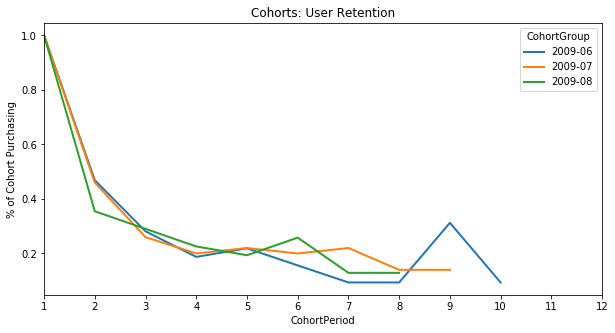

In [43]:
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

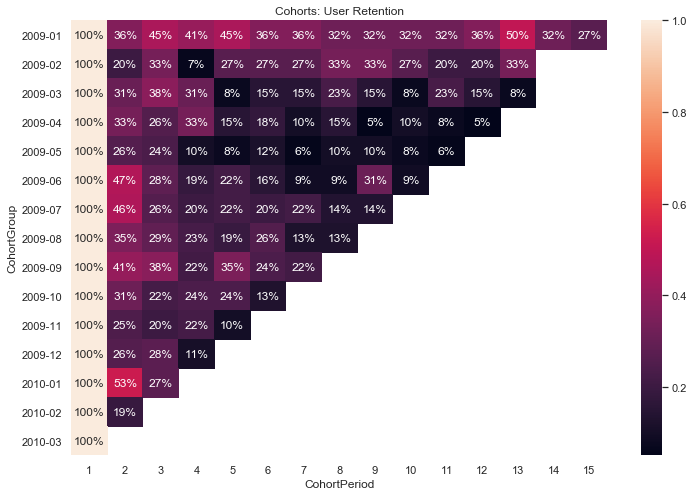

In [44]:
# Creating heatmaps in matplotlib is more difficult than it should be.
# Thankfully, Seaborn makes them easy for us.
# http://stanford.edu/~mwaskom/software/seaborn/

import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Unsurprisingly, we can see from the above chart that fewer users tend to purchase as time goes on.

However, we can also see that the 2009-01 cohort is the strongest, which enables us to ask targeted questions about this cohort compared to others -- what other attributes (besides first purchase month) do these users share which might be causing them to stick around? How were the majority of these users acquired? Was there a specific marketing campaign that brought them in? Did they take advantage of a promotion at sign-up? The answers to these questions would inform future marketing and product efforts.